In [1]:
import sys
assert sys.version_info >= (3, 7)

Note that you need python 3.7 to have use datetime.datetime.fromisoformat()

In [2]:
import numpy as np
from functions import split
from functions import pipeline
from functions import load_data
from functions import compute_f1
from functions import corr_matrix
from functions import plot_feature
from functions import print_sample
from functions import convert_date
from functions import convert_type
from functions import print_feature
from functions import remove_missing
from functions import delete_feature
from functions import convert_one_hot
from functions import convert_weather
from functions import feature_output_corr
from functions import normalization_feature

# Loading and Preprocessing :

* path : (STRING) path of the file to load.
* limit : (INT) limit the number of example to load.
* delete_features : (LIST) feature names to remove.
* cvrt_date : (BOOLEAN) convert the data
* weather : (LIST) weather to consider. All other will be dropped.
* one_hot_features : (LIST) feature names to convert in one-hot vector.
* norm_features : (LIST) feature names to normalize in one-hot vector
* missing_features (LIST) feature which missing values are to replace 
* missing_values   (LIST) value with which to replace the missing values

### Training file:

In [3]:
header, x, y, label = pipeline(path="data/training.csv", limit=300000,
                               one_hot_features=["Weekday"],
                               norm_features=[
                                   "Temperature (°C)", "Drew point (°C)", "Visibility (km)",
                                   "Relativite humidity (%)", "wind direction (10s deg)",
                                   "Wind speed (km/h)", "Pressure at the station (kPa)"],
                               delete_features=["Visility indicator", "hmdx", "Wind Chill"]
                              )

Data loaded (1.5s)
Visility indicator deleted (0.7s)
hmdx deleted (0.3s)
Wind Chill deleted (0.3s)
Date splited in Year/Month/Day/Hour/Weekday (1.7s)
Weekday converted in one-hot vector (2.9s)
Weather converted (7.2s)
Replace missing values (0.3s)
Remove samples with missing values (2.3s)
Data converted to float (8.0s)
Temperature (°C) normalized (0.0s)
Drew point (°C) normalized (0.0s)
Visibility (km) normalized (0.0s)
Relativite humidity (%) normalized (0.0s)
wind direction (10s deg) normalized (0.0s)
Wind speed (km/h) normalized (0.0s)
Pressure at the station (kPa) normalized (0.0s)
split data into x, y, and label (0.2s)


### Test file:

In [4]:
header_test, x_test, _, _ = pipeline(path="data/test.csv",
                                     one_hot_features=["Weekday"],
                                     norm_features=[
                                         "Temperature (°C)", "Drew point (°C)", "Visibility (km)",
                                         "Relativite humidity (%)", "wind direction (10s deg)",
                                         "Wind speed (km/h)", "Pressure at the station (kPa)"],
                                      delete_features=["Visility indicator", "hmdx", "Wind Chill"]
                                     )

Data loaded (1.7s)
Visility indicator deleted (0.4s)
hmdx deleted (0.2s)
Wind Chill deleted (0.1s)
Date splited in Year/Month/Day/Hour/Weekday (1.5s)
Weekday converted in one-hot vector (2.3s)
Weather converted (6.7s)
Replace missing values (0.2s)
Remove samples with missing values (1.8s)
Data converted to float (7.0s)
Temperature (°C) normalized (0.0s)
Drew point (°C) normalized (0.0s)
Visibility (km) normalized (0.0s)
Relativite humidity (%) normalized (0.0s)
wind direction (10s deg) normalized (0.0s)
Wind speed (km/h) normalized (0.0s)
Pressure at the station (kPa) normalized (0.0s)
split data into x, y, and label (0.3s)


In [5]:
# index = np.where(header == "Station Code")
# stations = list(set(x[:, index[0][0]]))

# x_stations = [[] for _ in range(len(stations))]
# y_stations = [[] for _ in range(len(stations))]
# label_stations = [[] for _ in range(len(stations))]

# for _x, _y, _label in zip(x, y, label):
#     s = stations.index(_x[index])
#     x_stations[s].append(_x)
#     y_stations[s].append(_y)
#     label_stations[s].append(_label)

### Deleting Outliers

In [6]:
print("Quantile at 0.99:", np.quantile(y, 0.99))
print("10 Highest values:", sorted(y, reverse = True)[0:10])

Quantile at 0.99: 17.0
10 Highest values: [169.0, 156.0, 125.0, 109.0, 72.0, 65.0, 65.0, 65.0, 60.0, 59.0]


In [7]:
non_out_ind = np.where(y < 50)
x, y, label = x[non_out_ind], y[non_out_ind], label[non_out_ind]

#### Distribution of the withdrawals:

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


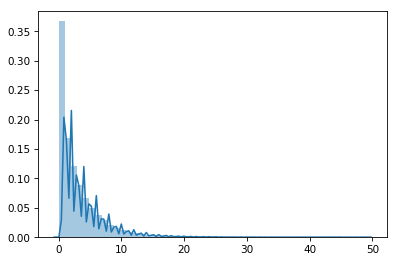

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4), dpi=75)
sns.distplot(y)
plt.show()

To reduce the tail of the distribution, we apply the square root function to to $y$ :

In [9]:
y = np.sqrt(y)

split = int(x.shape[0] * 0.8)
x_train, x_valid = x[:split], x[split:]
y_train, y_valid = y[:split], y[split:]
label_train, label_valid = label[:split], label[split:]

### Forward Feature Selection 

In [10]:
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared


#Initialization variables
Y = y_train
X = x_train
k = 25
# k = len(header)

remaining_features = [i for i in range(len(header))]
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = fit_linear_reg(X[:,list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [11]:
for i in range(1,len(features_list)):
    features_list[i] = [f for f in features_list[i] if header[f] in header_test]

print('Forward stepwise subset selection')
for i in range(1,20):
    print('Number of features :', len(features_list[i]))
    print('Features :', features_list[i])
    print('RSS :', round(RSS_list[i]))
    print('R Squared :', R_squared_list[i])
    print("")

Forward stepwise subset selection
Number of features : 1
Features : [0]
RSS : 253387.0
R Squared : 0.14450746095062217

Number of features : 2
Features : [0, 2]
RSS : 227394.0
R Squared : 0.23226541270687315

Number of features : 3
Features : [0, 2, 12]
RSS : 213904.0
R Squared : 0.2778107900754896

Number of features : 4
Features : [0, 2, 12, 5]
RSS : 210973.0
R Squared : 0.28770585407083016

Number of features : 5
Features : [0, 2, 12, 5, 19]
RSS : 210057.0
R Squared : 0.2908002567598692

Number of features : 6
Features : [0, 2, 12, 5, 19, 18]
RSS : 209616.0
R Squared : 0.2922870284042547

Number of features : 7
Features : [0, 2, 12, 5, 19, 18, 10]
RSS : 209214.0
R Squared : 0.2936448997839509

Number of features : 8
Features : [0, 2, 12, 5, 19, 18, 10, 8]
RSS : 208882.0
R Squared : 0.294765183792986

Number of features : 9
Features : [0, 2, 12, 5, 19, 18, 10, 8, 7]
RSS : 208642.0
R Squared : 0.2955765076882696

Number of features : 10
Features : [0, 2, 12, 5, 19, 18, 10, 8, 7, 4]
RS

Features that we choose to keep :

In [12]:
features_keep = features_list[10]

x_train = x_train[:, features_keep]
x_valid = x_valid[:, features_keep]

### Linear regression on Withdrawals:

In [13]:
model_linear = LinearRegression()
model_linear = model_linear.fit(x_train, y_train)

y_pred = model_linear.predict(x_valid)

# The coefficients
print('Score: ', model_linear.score(x_valid, y_valid))
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_valid, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_valid, y_pred))

Score:  0.2974389876960305
Mean squared error: 0.88
Variance score: 0.30


### Logistic regression between Withdrawals and Volume:

In [14]:
from sklearn.linear_model import LogisticRegression

model_logit = LogisticRegression(max_iter=9999, class_weight={0: 1, 1: 6})
model_logit = model_logit.fit(y_train.reshape(-1,1), label_train)

print(model_logit.score(y_valid.reshape(-1,1), label_valid))
print(model_logit.score(model_linear.predict(x_valid).reshape(-1,1), label_valid))

C:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


1.0
0.9276123759486281


## Creation of the result file:

In [15]:
features_keep_test = [np.where(i == header_test)[0][0] 
                      for i in header[features_keep]]
x_test_f = x_test[:,features_keep_test]


In [16]:
label_pred = model_logit.predict(model_linear.predict(x_test_f).reshape(-1,1))

In [17]:
yi = np.where(header_test == "Year")
mi = np.where(header_test == "Month")
di = np.where(header_test == "Day")
hi = np.where(header_test == "Hour")
si = np.where(header_test == "Station Code")

results = [["id","volume"]]

for index,element in enumerate(x_test):
    string_element = "2016-{:02d}-{:02d}_{:02d}:00_{:4d}".format(int(element[mi]),
                                                                 int(element[di]),
                                                                 int(element[hi]),
                                                                 int(element[si]))
    results.append([string_element, str(bool(label_pred[index]))])

In [28]:
print(sum(model_logit.predict(model_linear.predict(x_valid).reshape(-1,1))))
print(sum(model_logit.predict(model_linear.predict(x_test_f).reshape(-1,1))))

0.0
0.0


In [18]:
import csv 

with open("data/results.csv", "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(results)